# Discover Invariant in Rotation

## Import Model

In [1]:
import torch as tch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
# from google.colab import drive
import sys, os
import math

In [2]:
# drive.mount('/content/mnt')
# nb_path = '/content/notebooks'
# os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0, nb_path)

In [3]:
device = 'cuda' if tch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
# Implement Dataset
class RotationDataset(Dataset):
    def __init__(self, size):
        unif1 = Uniform(0.1, 1)
        unif2 = Uniform(0, 2*math.pi)
        unif3 = Uniform(0.1, 1)
        unif4 = Uniform(0, 2*math.pi)
        unif5 = Uniform(0, 2*math.pi)

        r1 = unif1.sample([size]).float()
        th1 = unif2.sample([size]).float()
        r2 = unif3.sample([size]).float()
        th2 = unif4.sample([size]).float()
        th3 = unif5.sample([size]).float()

        self.X = tch.column_stack([r1*tch.cos(th1), r1*tch.sin(th1)])
        X_p = tch.column_stack([r1*tch.cos(th1+th3), r1*tch.sin(th1+th3)])
        X_n = tch.column_stack([r2*tch.cos(th2), r2*tch.sin(th2)])

        self.X = tch.vstack([self.X, self.X])
        self.X_pair = tch.vstack([X_p, X_n])

        # Labeling
        y_p = tch.zeros((X_p.shape[0], 1))
        y_n = tch.ones((X_n.shape[0], 1))
        self.y = tch.vstack([y_p, y_n])

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = tch.Tensor(self.X[idx])
        x_pair = tch.Tensor(self.X_pair[idx])
        y = tch.Tensor(self.y[idx])
        return x, x_pair, y

In [5]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.linear_relu = nn.Sequential(
            nn.Linear(2,100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.ReLU()
        )

    def forward(self, x1, x2):
        out1 = self.linear_relu(x1)
        out2 = self.linear_relu(x2)
        return out1, out2

In [6]:
class ContrastiveLoss(tch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = tch.mean((1-label) * tch.pow(euclidean_distance, 2) +
                                      (label) * tch.pow(tch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [7]:
#!ls

In [8]:
#drive_path = "drive/My Drive/Colab Notebooks/"

In [9]:
net = tch.load("model/snn_rot8.pt").to(device)

In [10]:
pi = tch.tensor(math.pi).float().to(device)

In [11]:
loss_fn = ContrastiveLoss()

## Test Model

In [12]:
test_set = RotationDataset(10000)
test_data = DataLoader(test_set, batch_size=100)

In [13]:
total_accuracy = 0
total_size = len(test_data)
for batch, samples in enumerate(test_data):
    x, x_p, y = samples
    x, x_p, y = x.to(device), x_p.to(device), y.to(device)
    with tch.no_grad():
        pred1, pred2 = net(x, x_p)
        idx = tch.flatten((tch.abs(pred1 - pred2) <= 0.2) == y)
        acc = tch.count_nonzero(idx)
        # print(f"Accuracy: {100-acc}%")
        total_accuracy += (1 - acc/100)
        # temp = tch.column_stack([pred1, pred2, y])
        # temp_val = temp[idx]
        # if len(temp_val) != 0:
        #     print(f"{batch} - {temp_val[:].tolist()}")
print(f"Average Accuracy: {total_accuracy/total_size*100}%")

Average Accuracy: 99.82501983642578%


## OLS with Bottleneck

In [14]:
def r2_score(output, target):
    target_mean = tch.mean(target)
    ss_tot = tch.sum((target - target_mean) ** 2)
    ss_res = tch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

### Order 1

In [15]:
X, X_p, Y = test_set[:]
X, X_p, Y = X.to(device), X_p.to(device), Y.to(device)

x, y = X_p[:, 0], X_p[:,1]
x, y = x.to(device), y.to(device)

net.eval()
with tch.no_grad():
    _, Z = net(X, X_p)
Z

tensor([[140.5728],
        [113.1597],
        [136.9590],
        ...,
        [104.1717],
        [133.9889],
        [ 95.6149]])

In [16]:
X_linear = tch.column_stack([tch.ones((len(x), 1)).float().to(device), x, y])

In [17]:
weight_linear = tch.mm(tch.linalg.pinv(X_linear), Z)
weight_linear

tensor([[ 7.8032e+01],
        [ 7.0057e-02],
        [-2.4682e-01]])

In [18]:
r2_score(tch.mm(X_linear, weight_linear), Z)

tensor(8.8215e-06)

### Order 2

In [19]:
X_quad = tch.column_stack([tch.ones((len(x), 1)).float().to(device), x, y, x*y, x**2, y**2])

In [20]:
X_quad.shape

torch.Size([20000, 6])

In [21]:
weight_quad = tch.mm(tch.linalg.pinv(X_quad), Z)
weight_quad

tensor([[ 3.2186e+01],
        [ 1.4698e-01],
        [ 8.4214e-02],
        [-7.2476e-02],
        [ 1.2344e+02],
        [ 1.2314e+02]])

In [22]:
r2_score(tch.mm(X_quad, weight_quad), Z)

tensor(0.9577)

## Polynomial Regression with NeuralNetwork

In [23]:
class PolyNet(nn.Module):
    def __init__(self):
        super(PolyNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)

In [24]:
net2 = PolyNet().to(device)

In [25]:
print(net2)

PolyNet(
  (model): Sequential(
    (0): Linear(in_features=6, out_features=1, bias=True)
    (1): ReLU()
  )
)


In [26]:
criterion = nn.MSELoss()
optimizer = tch.optim.Adam(net2.parameters(), lr=1)
scheduler = tch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

In [27]:
train_dataset = RotationDataset(100000)
train_data = DataLoader(train_dataset, batch_size=1000, shuffle=True)

val_dataset = RotationDataset(10000)
val_data = DataLoader(val_dataset, batch_size=1000)

In [28]:
def train(dataloader, net1, net2, criterion, optimizer):
    size = len(dataloader.dataset)
    train_loss = []
    net1.eval()
    for batch, sample in enumerate(dataloader):
        X, X_p, _ = sample
        X, X_p = X.to(device), X_p.to(device)
        with tch.no_grad():
            _, out = net1(X, X_p)
        a, b = X_p[:,0], X_p[:,1]
        Y = tch.column_stack([tch.ones((len(a), 1)).float().to(device), a, b, a*b, a**2, b**2])
        Z = net2(Y)
        loss = criterion(Z, out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, curr = loss.item(), (batch + 50) * X.shape[0]
            print(f"loss: {loss:>7f}  [{curr:>5d}/{size:>5d}]")
            train_loss.append(loss)
    return tch.mean(tch.tensor(train_loss).float().to(device))

In [29]:
def val_check(dataloader, net1, net2, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    net1.eval()
    net2.eval()
    test_loss, r2 = 0, 0
    with tch.no_grad():
        for X, X_p, y in dataloader:
            X, X_p, y = X.to(device), X_p.to(device), y.to(device)
            _, out = net1(X, X_p)
            a, b = X_p[:,0], X_p[:,1]
            Y = tch.column_stack([tch.ones((len(a), 1)).float().to(device), a, b, a*b, a**2, b**2])
            Z = net2(Y)
            test_loss += criterion(Z, out)
            r2 += r2_score(out, Z)
    test_loss /= num_batches
    r2 /= num_batches
    print(f"Validation Error: \n Score: {r2:>4f}, Avg loss: {test_loss:>8f}")
    # print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss, r2

In [30]:
epochs = 100
train_loss= []
val_loss = []
old_val = 1e+10
for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    train_loss.append(train(train_data, net, net2, criterion, optimizer))
    val, correct = val_check(val_data, net, net2, criterion)
    val_loss.append(val)
    scheduler.step(val)
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        print(f" Learning Rate: {lr:>8f}")
    if lr < 1e-6:
        break
    old_val = val
print("Done!")


Epoch 1
-------------------------------
loss: 7310.331543  [50000/200000]
loss: 671.797607  [100000/200000]
loss: 444.796509  [150000/200000]
loss: 278.500458  [200000/200000]
Validation Error: 
 Score: 0.748264, Avg loss: 166.745026
 Learning Rate: 1.000000

Epoch 2
-------------------------------
loss: 175.612000  [50000/200000]
loss: 102.642357  [100000/200000]
loss: 70.365822  [150000/200000]
loss: 68.607529  [200000/200000]
Validation Error: 
 Score: 0.949279, Avg loss: 60.698341
 Learning Rate: 1.000000

Epoch 3
-------------------------------
loss: 59.391590  [50000/200000]
loss: 53.415001  [100000/200000]
loss: 58.222393  [150000/200000]
loss: 55.656448  [200000/200000]
Validation Error: 
 Score: 0.955007, Avg loss: 58.427177
 Learning Rate: 1.000000

Epoch 4
-------------------------------
loss: 58.198696  [50000/200000]
loss: 58.646221  [100000/200000]
loss: 59.957634  [150000/200000]
loss: 56.446407  [200000/200000]
Validation Error: 
 Score: 0.955200, Avg loss: 58.474754
 

In [31]:
for param in net2.parameters():
  print(param.data)
  break

tensor([[ 1.6315e+01, -4.9054e-02,  2.5672e-02,  3.8535e-02,  1.2341e+02,
          1.2344e+02]])


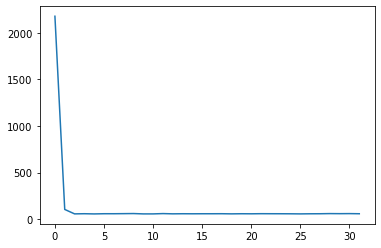

In [33]:
plt.plot(train_loss)

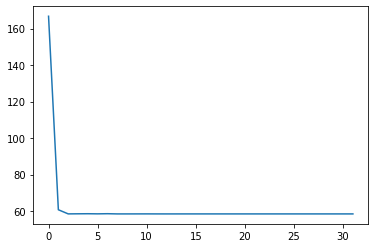

In [34]:
plt.plot(val_loss)